In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import json
import os
import matplotlib.pyplot as plt

# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed


In [2]:
# Set the random seed for multiple libraries to ensure repeatability

# set_seed(42)

In [3]:
def read_losses(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Extract the subfolder name as the series name
    series_name = os.path.basename(os.path.dirname(file_path))
    return series_name, data['training_losses'], data['validation_losses']

def plot_multiple_losses(files, log_y=False):
    plt.figure(figsize=(12, 6))
    
    for file_path in files:
        series_name, training_losses, validation_losses = read_losses(file_path)
        epochs = range(1, len(training_losses) + 1)
        

        # plt.plot(epochs, training_losses, 'o-', label=f'{series_name} Training', linewidth=2)
        
        plt.plot(epochs, validation_losses, 'o--', label=f'{series_name} Validation', linewidth=2)

    plt.title('Training and Validation Losses for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    if log_y:
        plt.yscale('log')  # Set the y-axis to logarithmic scale
    
    plt.show()

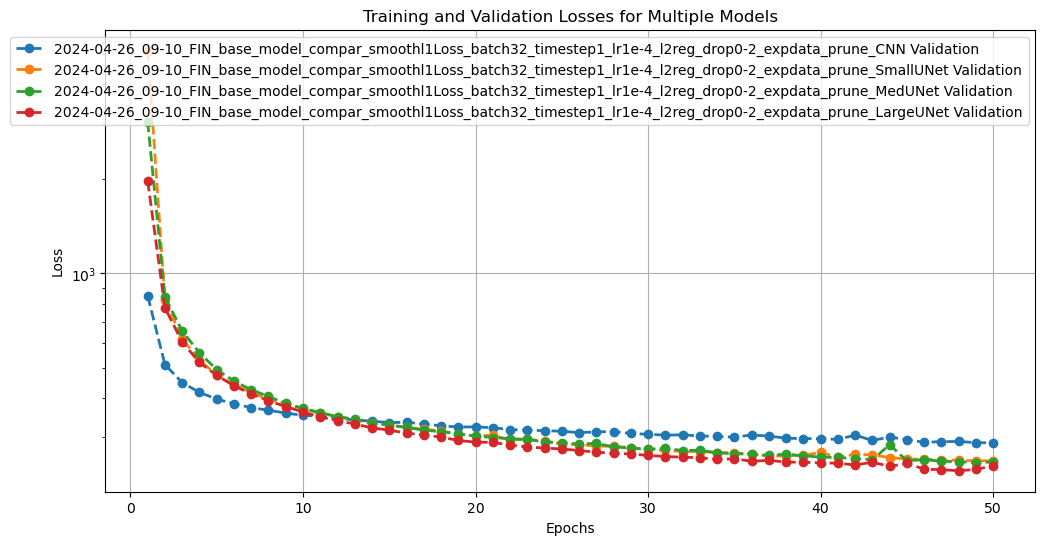

In [4]:
files = [
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_CNN/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_SmallUNet/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/losses_epoch_50.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_LargeUNet/losses_epoch_50.json'
]

plot_multiple_losses(files, log_y=True)

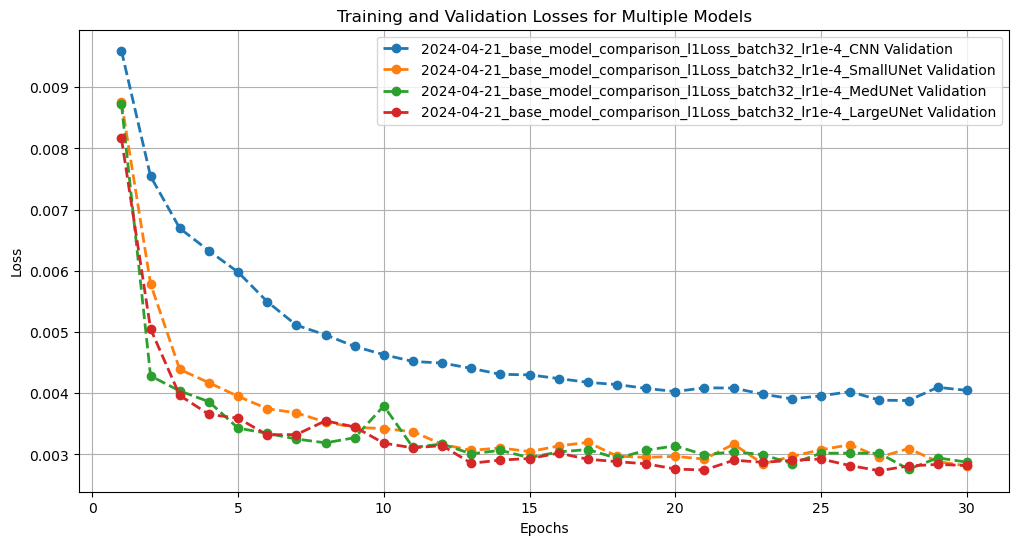

In [5]:
files = [
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_CNN/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_SmallUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_MedUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-21_base_model_comparison_l1Loss_batch32_lr1e-4_LargeUNet/losses_epoch_30.json'
]

plot_multiple_losses(files)

In [6]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment_prune'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 30

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [7]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True, timestep_interval=1)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 3665
Train size: 2647, Validation size: 556, Test size: 462


In [8]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    med_unet = nn.DataParallel(med_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(med_unet.parameters(), lr=1e-3)

med_unet_trainer = TrainerPairs(med_unet, optimizer, criterion, device, model_name="med_unet", checkpoint_dir=checkpoint_dir)

med_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/model_epoch_50.pth", train_loader)

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-26_09-10_FIN_base_model_compar_smoothl1Loss_batch32_timestep1_lr1e-4_l2reg_drop0-2_expdata_prune_MedUNet/model_epoch_50.pth


In [9]:
# med_unet_trainer.test(test_loader)

In [10]:
# med_unet_trainer.plot_predictions(test_loader, num_predictions=5)

In [11]:
# med_unet_trainer.plot_predictions6(test_loader, num_predictions=5)

# THIS IS THE NEW STUFF TO TRY REGARDING INFER vs REAL

In [12]:
# def plot_real_vs_inferred(real_states, inferred_states, n=5):
#     num_timesteps = len(real_states)
#     timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

#     for timestep in timesteps_to_plot:
#         real_state = real_states[timestep]
#         inferred_state = inferred_states[timestep]

#         # Extract velocity and thickness from real and inferred states
#         real_velocity = real_state[1]
#         real_thickness = real_state[0]
#         inferred_velocity = inferred_state[1]
#         inferred_thickness = inferred_state[0]

#         # Calculate differences
#         velocity_diff = np.abs(real_velocity - inferred_velocity)
#         thickness_diff = np.abs(real_thickness - inferred_thickness)

#         plt.figure(figsize=(20, 8))

#         # Row 1: Real Velocity, Inferred Velocity, Velocity Difference
#         plt.subplot(2, 3, 1)
#         plt.imshow(real_velocity, cmap='jet')
#         plt.title(f'Real Velocity (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 2)
#         plt.imshow(inferred_velocity, cmap='jet')
#         plt.title(f'Inferred Velocity (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 3)
#         plt.imshow(velocity_diff, cmap='jet')
#         plt.title(f'Velocity Difference (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         # Row 2: Real Thickness, Inferred Thickness, Thickness Difference
#         plt.subplot(2, 3, 4)
#         plt.imshow(real_thickness, cmap='jet')
#         plt.title(f'Real Thickness (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 5)
#         plt.imshow(inferred_thickness, cmap='jet')
#         plt.title(f'Inferred Thickness (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 6)
#         plt.imshow(thickness_diff, cmap='jet')
#         plt.title(f'Thickness Difference (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.tight_layout()
#         plt.show()

#     # Stack all inferred arrays and all actual arrays
#     stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
#     stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
#     stacked_real_velocity = np.stack([state[1] for state in real_states.values()], axis=0)
#     stacked_real_thickness = np.stack([state[0] for state in real_states.values()], axis=0)

#     # Plot stacked arrays side by side
#     plt.figure(figsize=(20, 8))

#     plt.subplot(2, 3, 1)
#     plt.imshow(stacked_real_velocity.max(axis=0), cmap='jet')
#     plt.title('Stacked Real Velocity')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 2)
#     plt.imshow(stacked_inferred_velocity.max(axis=0), cmap='jet')
#     plt.title('Stacked Inferred Velocity')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 3)
#     plt.imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet')
#     plt.title('Stacked Velocity Difference')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 4)
#     plt.imshow(stacked_real_thickness.max(axis=0), cmap='jet')
#     plt.title('Stacked Real Thickness')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 5)
#     plt.imshow(stacked_inferred_thickness.max(axis=0), cmap='jet')
#     plt.title('Stacked Inferred Thickness')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 6)
#     plt.imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet')
#     plt.title('Stacked Thickness Difference')
#     plt.axis('off')
#     plt.colorbar()

#     plt.tight_layout()
#     plt.show()

# def plot_real_vs_inferred(real_states, inferred_states, n=5):
#     num_timesteps = len(real_states)
#     timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

#     for timestep in timesteps_to_plot:
#         real_state = real_states[timestep]
#         inferred_state = inferred_states[timestep]

#         # Extract velocity and thickness from real and inferred states
#         real_velocity = real_state[1]
#         real_thickness = real_state[0]
#         inferred_velocity = inferred_state[1]
#         inferred_thickness = inferred_state[0]

#         # Calculate differences
#         velocity_diff = np.abs(real_velocity - inferred_velocity)
#         thickness_diff = np.abs(real_thickness - inferred_thickness)

#         # Find the maximum and minimum values for this timestep
#         max_value = max(np.max(real_velocity), np.max(inferred_velocity), np.max(velocity_diff),
#                         np.max(real_thickness), np.max(inferred_thickness), np.max(thickness_diff))
#         min_value = min(np.min(real_velocity), np.min(inferred_velocity), np.min(velocity_diff),
#                         np.min(real_thickness), np.min(inferred_thickness), np.min(thickness_diff))

#         plt.figure(figsize=(20, 8))

#         # Row 1: Real Velocity, Inferred Velocity, Velocity Difference
#         plt.subplot(2, 3, 1)
#         plt.imshow(real_velocity, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Real Velocity (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 2)
#         plt.imshow(inferred_velocity, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Inferred Velocity (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 3)
#         plt.imshow(velocity_diff, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Velocity Difference (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         # Row 2: Real Thickness, Inferred Thickness, Thickness Difference
#         plt.subplot(2, 3, 4)
#         plt.imshow(real_thickness, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Real Thickness (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 5)
#         plt.imshow(inferred_thickness, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Inferred Thickness (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.subplot(2, 3, 6)
#         plt.imshow(thickness_diff, cmap='jet', vmin=min_value, vmax=max_value)
#         plt.title(f'Thickness Difference (Timestep {timestep})')
#         plt.axis('off')
#         plt.colorbar()

#         plt.tight_layout()
#         plt.show()

#     # Stack all inferred arrays and all actual arrays
#     stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
#     stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
#     stacked_real_velocity = np.stack([state[1] for state in real_states.values()], axis=0)
#     stacked_real_thickness = np.stack([state[0] for state in real_states.values()], axis=0)

#     # Plot stacked arrays side by side
#     plt.figure(figsize=(20, 8))

#     plt.subplot(2, 3, 1)
#     plt.imshow(stacked_real_velocity.max(axis=0), cmap='jet')
#     plt.title('Stacked Real Velocity')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 2)
#     plt.imshow(stacked_inferred_velocity.max(axis=0), cmap='jet')
#     plt.title('Stacked Inferred Velocity')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 3)
#     plt.imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet')
#     plt.title('Stacked Velocity Difference')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 4)
#     plt.imshow(stacked_real_thickness.max(axis=0), cmap='jet')
#     plt.title('Stacked Real Thickness')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 5)
#     plt.imshow(stacked_inferred_thickness.max(axis=0), cmap='jet')
#     plt.title('Stacked Inferred Thickness')
#     plt.axis('off')
#     plt.colorbar()

#     plt.subplot(2, 3, 6)
#     plt.imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet')
#     plt.title('Stacked Thickness Difference')
#     plt.axis('off')
#     plt.colorbar()

#     plt.tight_layout()
#     plt.show()

# import os

def plot_real_vs_inferred(real_states, inferred_states, base_folder, model_id, suffix='', n=5):
    num_timesteps = len(real_states)
    timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

    # Create the folder for the model_id with the suffix if provided
    model_folder = os.path.join(base_folder, str(model_id) + suffix)
    os.makedirs(model_folder, exist_ok=True)

    for timestep in timesteps_to_plot:
        real_state = real_states[timestep]
        inferred_state = inferred_states[timestep]

        # Extract velocity and thickness from real and inferred states
        real_velocity = real_state[0]  # Real velocity is at index 0
        real_thickness = real_state[1]  # Real thickness is at index 1
        inferred_velocity = inferred_state[1]  # Inferred velocity is at index 1
        inferred_thickness = inferred_state[0]  # Inferred thickness is at index 0

        # Calculate differences
        velocity_diff = np.abs(real_velocity - inferred_velocity)
        thickness_diff = np.abs(real_thickness - inferred_thickness)

        # Determine the common color scales for velocities and thicknesses
        velocity_min = min(np.min(real_velocity), np.min(inferred_velocity), np.min(velocity_diff))
        velocity_max = max(np.max(real_velocity), np.max(inferred_velocity), np.max(velocity_diff))
        thickness_min = min(np.min(real_thickness), np.min(inferred_thickness), np.min(thickness_diff))
        thickness_max = max(np.max(real_thickness), np.max(inferred_thickness), np.max(thickness_diff))

        fig, axes = plt.subplots(2, 3, figsize=(20, 8))
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

        # Row 1: Real Velocity, Inferred Velocity, Velocity Difference
        axes[0, 0].imshow(real_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max)
        axes[0, 0].set_title(f'Real Velocity (Timestep {timestep})')
        axes[0, 0].axis('off')
        fig.colorbar(axes[0, 0].imshow(real_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 0])

        axes[0, 1].imshow(inferred_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max)
        axes[0, 1].set_title(f'Inferred Velocity (Timestep {timestep})')
        axes[0, 1].axis('off')
        fig.colorbar(axes[0, 1].imshow(inferred_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 1])

        axes[0, 2].imshow(velocity_diff, cmap='jet', vmin=velocity_min, vmax=velocity_max)
        axes[0, 2].set_title(f'Velocity Difference (Timestep {timestep})')
        axes[0, 2].axis('off')
        fig.colorbar(axes[0, 2].imshow(velocity_diff, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 2])

        # Row 2: Real Thickness, Inferred Thickness, Thickness Difference
        axes[1, 0].imshow(real_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max)
        axes[1, 0].set_title(f'Real Thickness (Timestep {timestep})')
        axes[1, 0].axis('off')
        fig.colorbar(axes[1, 0].imshow(real_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 0])

        axes[1, 1].imshow(inferred_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max)
        axes[1, 1].set_title(f'Inferred Thickness (Timestep {timestep})')
        axes[1, 1].axis('off')
        fig.colorbar(axes[1, 1].imshow(inferred_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 1])

        axes[1, 2].imshow(thickness_diff, cmap='jet', vmin=thickness_min, vmax=thickness_max)
        axes[1, 2].set_title(f'Thickness Difference (Timestep {timestep})')
        axes[1, 2].axis('off')
        fig.colorbar(axes[1, 2].imshow(thickness_diff, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 2])

        plt.tight_layout()
        plt.show()  # Display the plot in the notebook

        # Save the figure as a 300 dpi PNG file
        filename = f'state_{timestep}.png'
        save_path = os.path.join(model_folder, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)

    # Stack all inferred arrays and all actual arrays
    stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
    stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
    stacked_real_velocity = np.stack([state[0] for state in real_states.values()], axis=0)
    stacked_real_thickness = np.stack([state[1] for state in real_states.values()], axis=0)

    # Determine the common color scales for stacked velocities and thicknesses
    stacked_velocity_min = min(np.min(stacked_real_velocity), np.min(stacked_inferred_velocity))
    stacked_velocity_max = max(np.max(stacked_real_velocity), np.max(stacked_inferred_velocity))
    stacked_thickness_min = min(np.min(stacked_real_thickness), np.min(stacked_inferred_thickness))
    stacked_thickness_max = max(np.max(stacked_real_thickness), np.max(stacked_inferred_thickness))

    # Plot stacked arrays side by side
    fig, axes = plt.subplots(2, 3, figsize=(20, 8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    axes[0, 0].imshow(stacked_real_velocity.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
    axes[0, 0].set_title('Stacked Real Velocity')
    axes[0, 0].axis('off')
    fig.colorbar(axes[0, 0].imshow(stacked_real_velocity.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 0])

    axes[0, 1].imshow(stacked_inferred_velocity.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
    axes[0, 1].set_title('Stacked Inferred Velocity')
    axes[0, 1].axis('off')
    fig.colorbar(axes[0, 1].imshow(stacked_inferred_velocity.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 1])

    axes[0, 2].imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
    axes[0, 2].set_title('Stacked Velocity Difference')
    axes[0, 2].axis('off')
    fig.colorbar(axes[0, 2].imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 2])

    axes[1, 0].imshow(stacked_real_thickness.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
    axes[1, 0].set_title('Stacked Real Thickness')
    axes[1, 0].axis('off')
    fig.colorbar(axes[1, 0].imshow(stacked_real_thickness.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 0])

    axes[1, 1].imshow(stacked_inferred_thickness.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
    axes[1, 1].set_title('Stacked Inferred Thickness')
    axes[1, 1].axis('off')
    fig.colorbar(axes[1, 1].imshow(stacked_inferred_thickness.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 1])

    axes[1, 2].imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
    axes[1, 2].set_title('Stacked Thickness Difference')
    axes[1, 2].axis('off')
    fig.colorbar(axes[1, 2].imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 2])

    plt.tight_layout()
    plt.show()  # Display the stacked plot in the notebook

    # Save the stacked plot as a 300 dpi PNG file
    filename = 'stacked_plots.png'
    save_path = os.path.join(model_folder, filename)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

# def plot_real_vs_inferred(real_states, inferred_states, base_folder, model_id, suffix='', n=5):
#     num_timesteps = len(real_states)
#     timesteps_to_plot = range(1, num_timesteps + 1, n)  # Start from 1 and go up to num_timesteps + 1

#     # Create the folder for the model_id with the suffix if provided
#     model_folder = os.path.join(base_folder, str(model_id) + suffix)
#     os.makedirs(model_folder, exist_ok=True)

#     for timestep in timesteps_to_plot:
#         real_state = real_states[timestep]
#         inferred_state = inferred_states[timestep]

#         # Extract velocity and thickness from real and inferred states
#         real_velocity = real_state[0]  # Real velocity is at index 0
#         real_thickness = real_state[1]  # Real thickness is at index 1
#         inferred_velocity = inferred_state[1]  # Inferred velocity is at index 1
#         inferred_thickness = inferred_state[0]  # Inferred thickness is at index 0

#         # Calculate differences
#         velocity_diff = np.abs(real_velocity - inferred_velocity)
#         thickness_diff = np.abs(real_thickness - inferred_thickness)

#         # Determine the common color scales for velocities and thicknesses
#         velocity_min = min(np.min(real_velocity), np.min(inferred_velocity), np.min(velocity_diff))
#         velocity_max = max(np.max(real_velocity), np.max(inferred_velocity), np.max(velocity_diff))
#         thickness_min = min(np.min(real_thickness), np.min(inferred_thickness), np.min(thickness_diff))
#         thickness_max = max(np.max(real_thickness), np.max(inferred_thickness), np.max(thickness_diff))

#         fig, axes = plt.subplots(2, 3, figsize=(20, 8))
#         plt.subplots_adjust(wspace=0.3, hspace=0.3)

#         # Row 1: Real Thickness, Inferred Thickness, Thickness Difference
#         axes[0, 0].imshow(real_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max)
#         axes[0, 0].set_title(f'Real Thickness (Timestep {timestep})')  # Swapped title
#         axes[0, 0].axis('off')
#         fig.colorbar(axes[0, 0].imshow(real_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 0])

#         axes[0, 1].imshow(inferred_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max)
#         axes[0, 1].set_title(f'Inferred Thickness (Timestep {timestep})')  # Swapped title
#         axes[0, 1].axis('off')
#         fig.colorbar(axes[0, 1].imshow(inferred_velocity, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 1])

#         axes[0, 2].imshow(velocity_diff, cmap='jet', vmin=velocity_min, vmax=velocity_max)
#         axes[0, 2].set_title(f'Thickness Difference (Timestep {timestep})')  # Swapped title
#         axes[0, 2].axis('off')
#         fig.colorbar(axes[0, 2].imshow(velocity_diff, cmap='jet', vmin=velocity_min, vmax=velocity_max), ax=axes[0, 2])

#         # Row 2: Real Velocity, Inferred Velocity, Velocity Difference
#         axes[1, 0].imshow(real_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max)
#         axes[1, 0].set_title(f'Real Velocity (Timestep {timestep})')  # Swapped title
#         axes[1, 0].axis('off')
#         fig.colorbar(axes[1, 0].imshow(real_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 0])

#         axes[1, 1].imshow(inferred_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max)
#         axes[1, 1].set_title(f'Inferred Velocity (Timestep {timestep})')  # Swapped title
#         axes[1, 1].axis('off')
#         fig.colorbar(axes[1, 1].imshow(inferred_thickness, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 1])

#         axes[1, 2].imshow(thickness_diff, cmap='jet', vmin=thickness_min, vmax=thickness_max)
#         axes[1, 2].set_title(f'Velocity Difference (Timestep {timestep})')  # Swapped title
#         axes[1, 2].axis('off')
#         fig.colorbar(axes[1, 2].imshow(thickness_diff, cmap='jet', vmin=thickness_min, vmax=thickness_max), ax=axes[1, 2])

#         plt.tight_layout()
#         plt.show()  # Display the plot in the notebook

#         # Save the figure as a 300 dpi PNG file
#         filename = f'state_{timestep}.png'
#         save_path = os.path.join(model_folder, filename)
#         fig.savefig(save_path, dpi=300, bbox_inches='tight')
#         plt.close(fig)

#     # Stack all inferred arrays and all actual arrays
#     stacked_inferred_velocity = np.stack([state[1] for state in inferred_states.values()], axis=0)
#     stacked_inferred_thickness = np.stack([state[0] for state in inferred_states.values()], axis=0)
#     stacked_real_velocity = np.stack([state[0] for state in real_states.values()], axis=0)
#     stacked_real_thickness = np.stack([state[1] for state in real_states.values()], axis=0)

#     # Determine the common color scales for stacked velocities and thicknesses
#     stacked_velocity_min = min(np.min(stacked_real_thickness), np.min(stacked_inferred_thickness))
#     stacked_velocity_max = max(np.max(stacked_real_thickness), np.max(stacked_inferred_thickness))
#     stacked_thickness_min = min(np.min(stacked_real_velocity), np.min(stacked_inferred_velocity))
#     stacked_thickness_max = max(np.max(stacked_real_velocity), np.max(stacked_inferred_velocity))

#     # Plot stacked arrays side by side
#     fig, axes = plt.subplots(2, 3, figsize=(20, 8))
#     plt.subplots_adjust(wspace=0.3, hspace=0.3)

#     axes[0, 0].imshow(stacked_real_thickness.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
#     axes[0, 0].set_title('Stacked Real Thickness')  # Swapped title
#     axes[0, 0].axis('off')
#     fig.colorbar(axes[0, 0].imshow(stacked_real_thickness.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 0])

#     axes[0, 1].imshow(stacked_inferred_thickness.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
#     axes[0, 1].set_title('Stacked Inferred Thickness')  # Swapped title
#     axes[0, 1].axis('off')
#     fig.colorbar(axes[0, 1].imshow(stacked_inferred_thickness.max(axis=0), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 1])

#     axes[0, 2].imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max)
#     axes[0, 2].set_title('Stacked Thickness Difference')  # Swapped title
#     axes[0, 2].axis('off')
#     fig.colorbar(axes[0, 2].imshow(np.abs(stacked_real_thickness.max(axis=0) - stacked_inferred_thickness.max(axis=0)), cmap='jet', vmin=stacked_velocity_min, vmax=stacked_velocity_max), ax=axes[0, 2])

#     axes[1, 0].imshow(stacked_real_velocity.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
#     axes[1, 0].set_title('Stacked Real Velocity')  # Swapped title
#     axes[1, 0].axis('off')
#     fig.colorbar(axes[1, 0].imshow(stacked_real_velocity.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 0])

#     axes[1, 1].imshow(stacked_inferred_velocity.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
#     axes[1, 1].set_title('Stacked Inferred Velocity')  # Swapped title
#     axes[1, 1].axis('off')
#     fig.colorbar(axes[1, 1].imshow(stacked_inferred_velocity.max(axis=0), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 1])

#     axes[1, 2].imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max)
#     axes[1, 2].set_title('Stacked Velocity Difference')  # Swapped title
#     axes[1, 2].axis('off')
#     fig.colorbar(axes[1, 2].imshow(np.abs(stacked_real_velocity.max(axis=0) - stacked_inferred_velocity.max(axis=0)), cmap='jet', vmin=stacked_thickness_min, vmax=stacked_thickness_max), ax=axes[1, 2])

#     plt.tight_layout()
#     plt.show()  # Display the stacked plot in the notebook

#     # Save the stacked plot as a 300 dpi PNG file
#     filename = 'stacked_plots.png'
#     save_path = os.path.join(model_folder, filename)
#     fig.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.close(fig)

def create_real_states_dict(root_dir, model_number, start_state, num_timesteps, array_size):
    real_states = {}
    
    model_dir = os.path.join(root_dir, str(model_number))
    velocity_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'velocity')
    thickness_dir = os.path.join(model_dir, f'04_FinalProcessedData_{array_size}', 'thickness')
    
    for t in range(num_timesteps):
        state_number = start_state + t
        
        velocity_file = os.path.join(velocity_dir, f'{model_number}_velocity_{state_number}.npy')
        thickness_file = os.path.join(thickness_dir, f'{model_number}_thickness_{state_number}.npy')
        
        velocity = np.load(velocity_file)
        thickness = np.load(thickness_file)
        
        real_states[t + 1] = np.stack((thickness, velocity), axis=0)  # Change the key to t + 1
    
    return real_states

## roughly how to use

Does some weird stuff with the class though

Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with elevation shape: torch.Size([1, 3, 256, 256])
Output with el

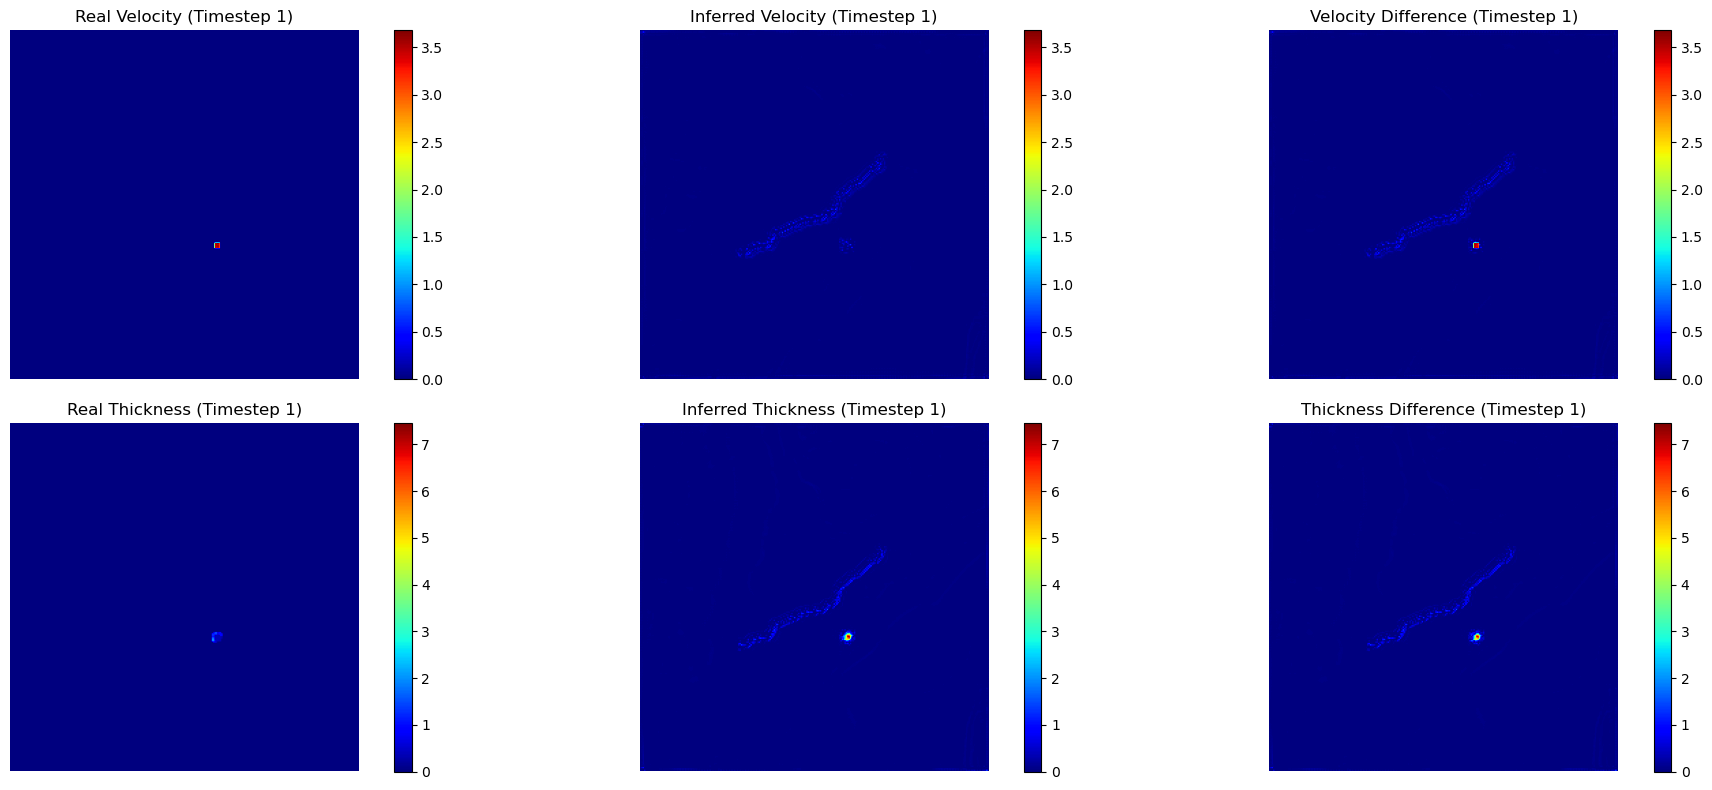

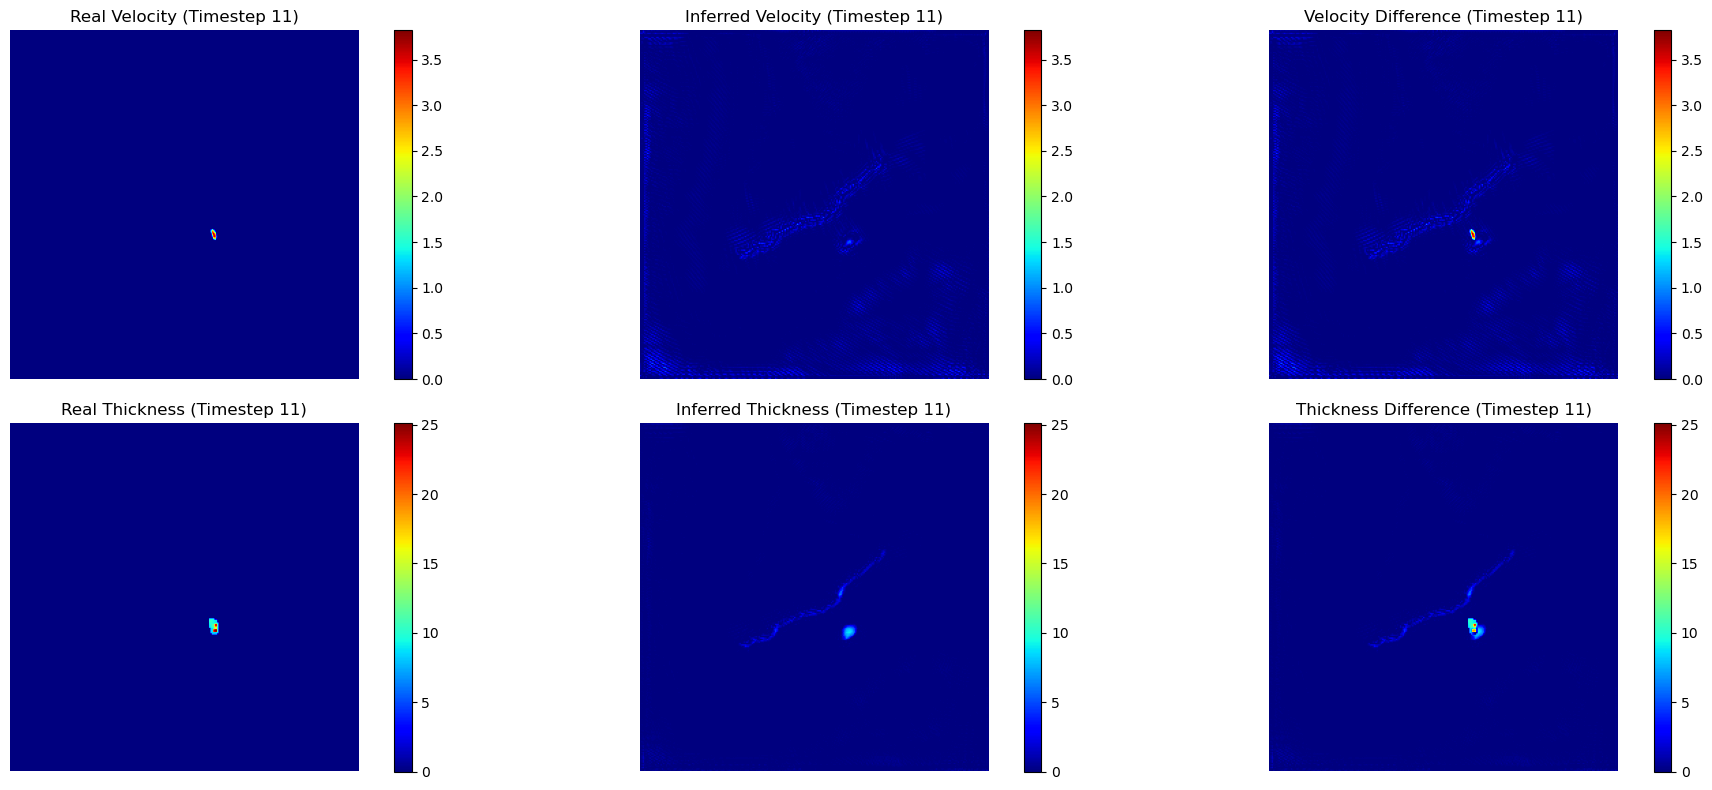

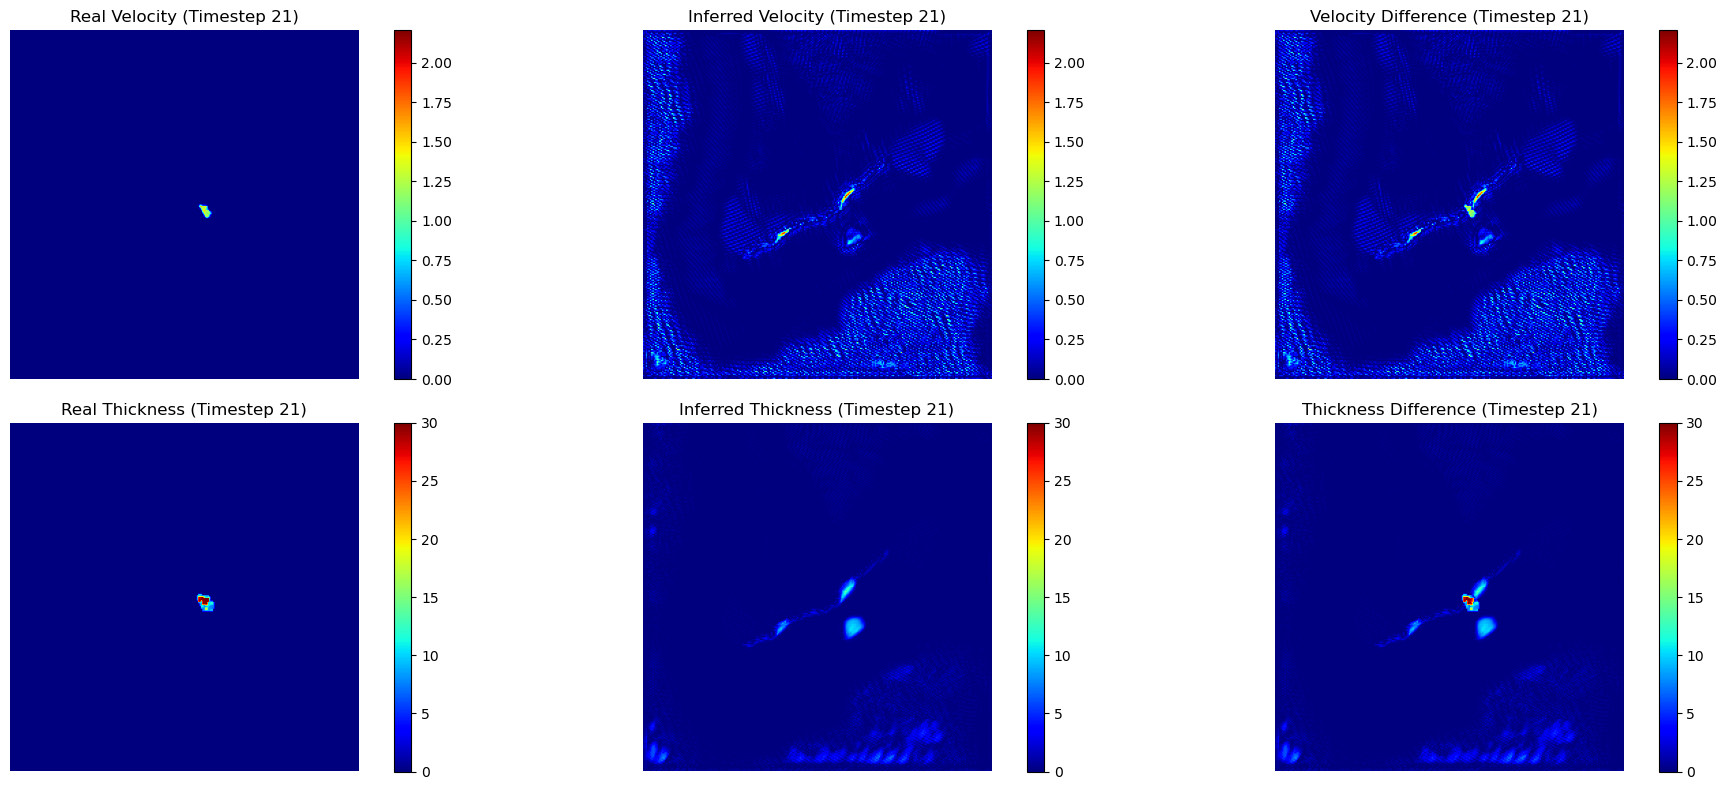

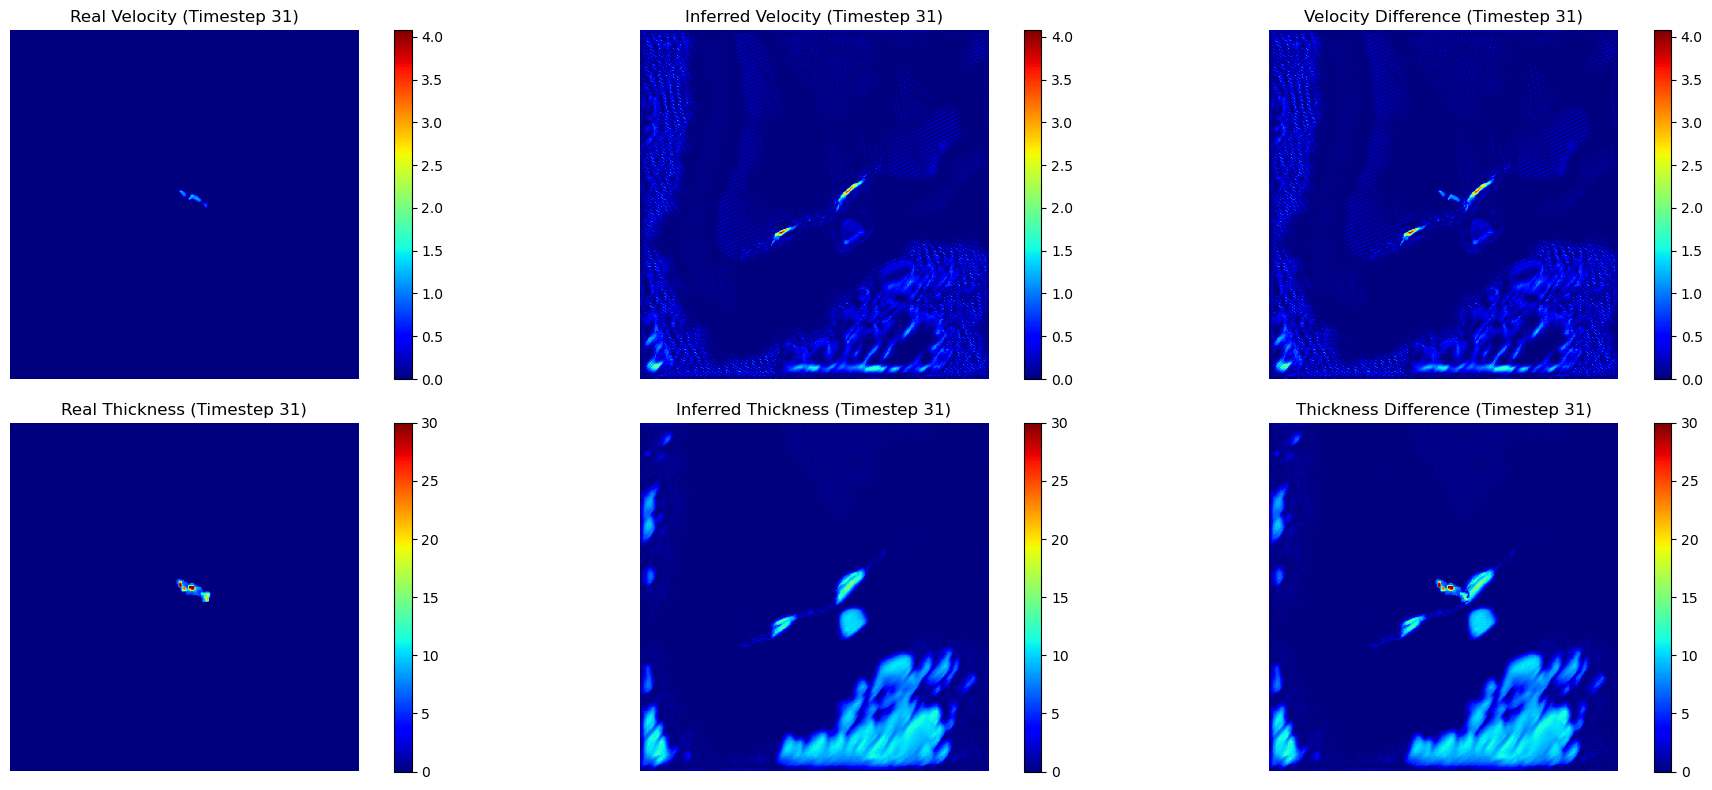

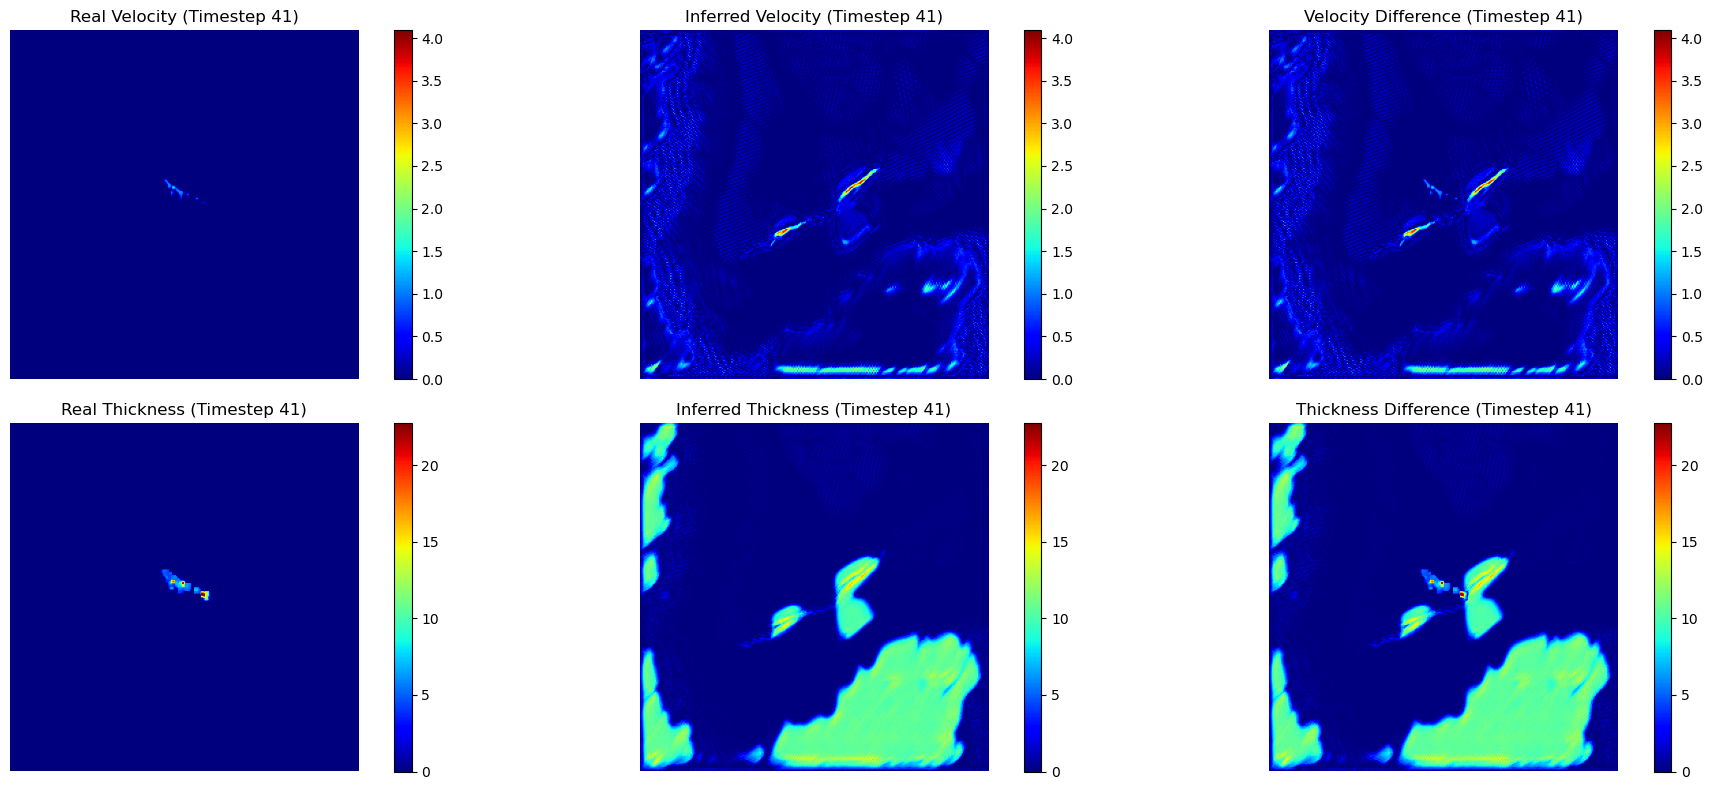

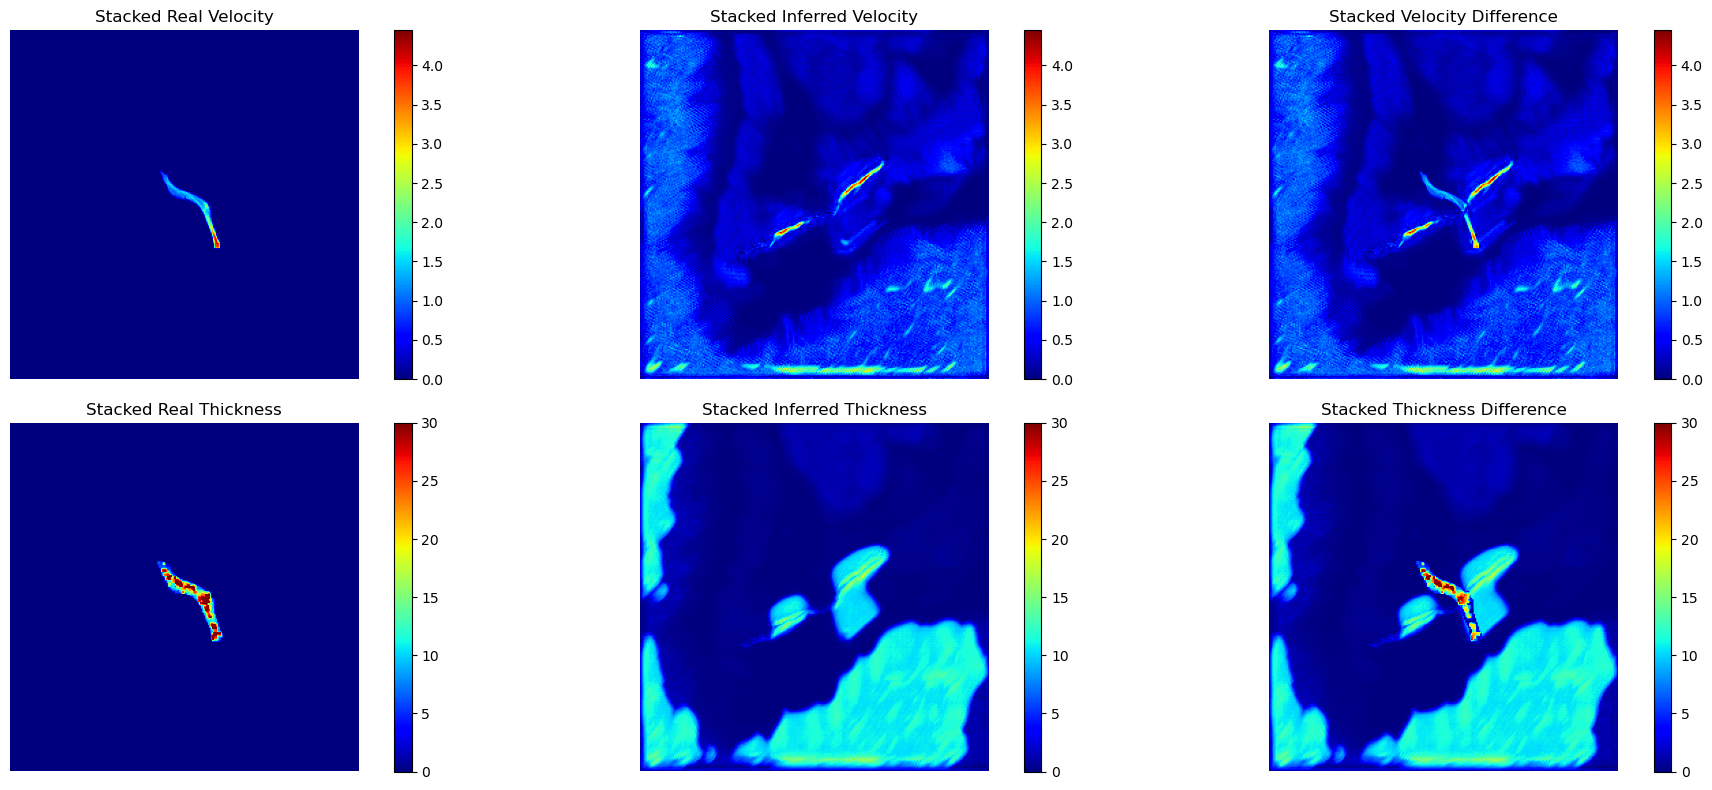

In [13]:
base_folder = "/home/tom/repos/dyna-landslide-surrogate/plots"

n = 10
num_timesteps = 50
model = "00076"
start = 2


# Create the initial input
initial_input = med_unet_trainer.create_inference_input(root_dir, model, start, 256)

# Perform inference

inferred_states = med_unet_trainer.infer(initial_input, num_timesteps)

# Create the real states dictionary
real_states = create_real_states_dict(root_dir, model, start + 1, num_timesteps, 256)

# Plot real vs inferred states
plot_real_vs_inferred(real_states, inferred_states, model_id=model, n=n, base_folder=base_folder, suffix="chain")

In [14]:
state_infer = med_unet_trainer.infer_from_real_states(real_states, num_timesteps)

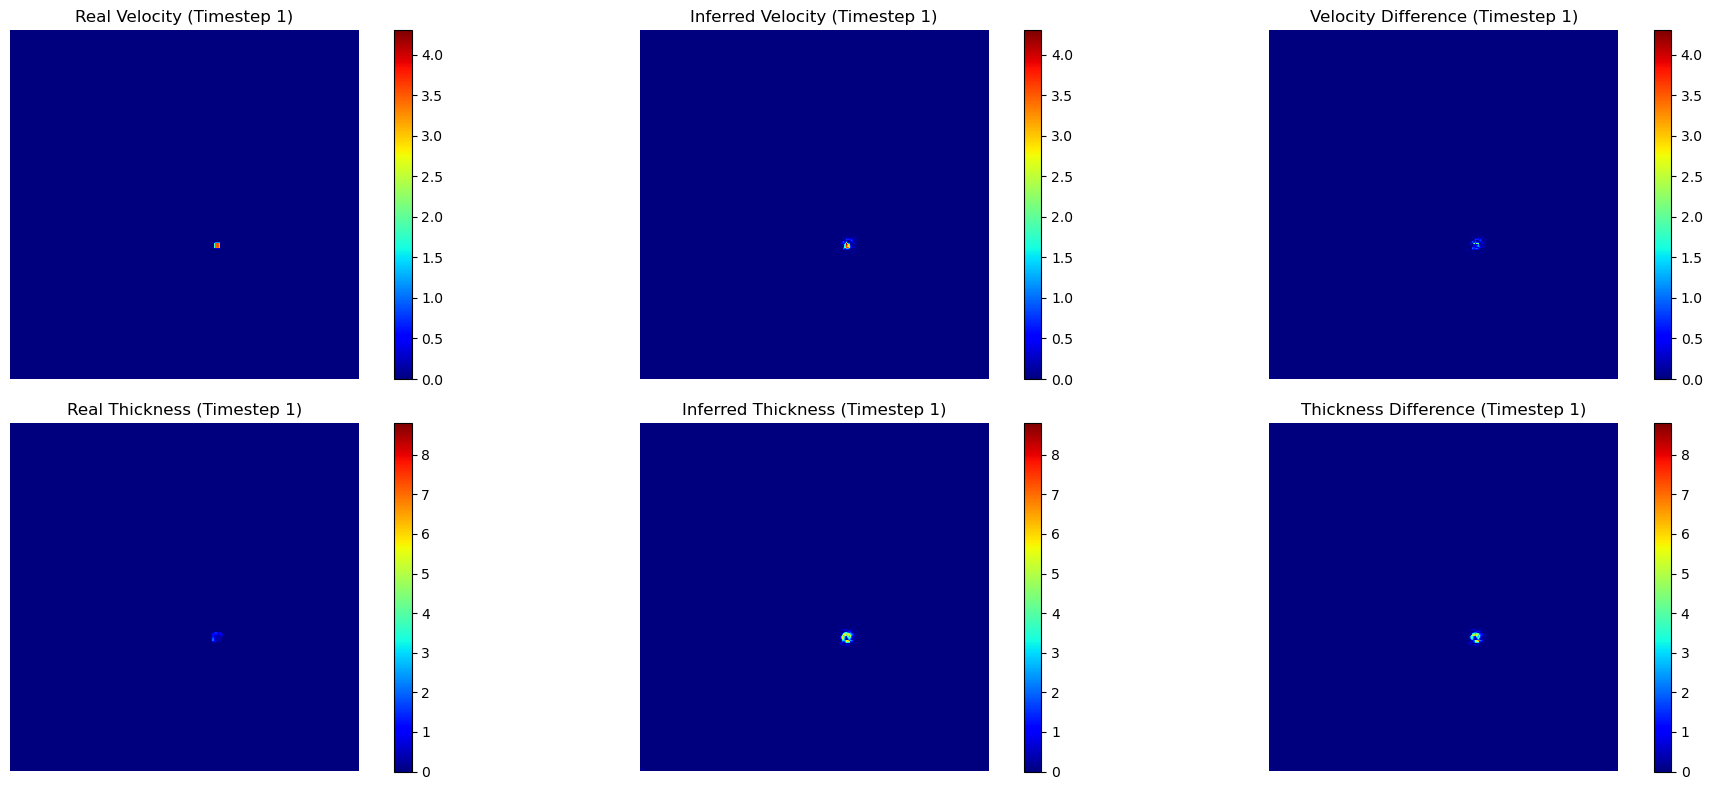

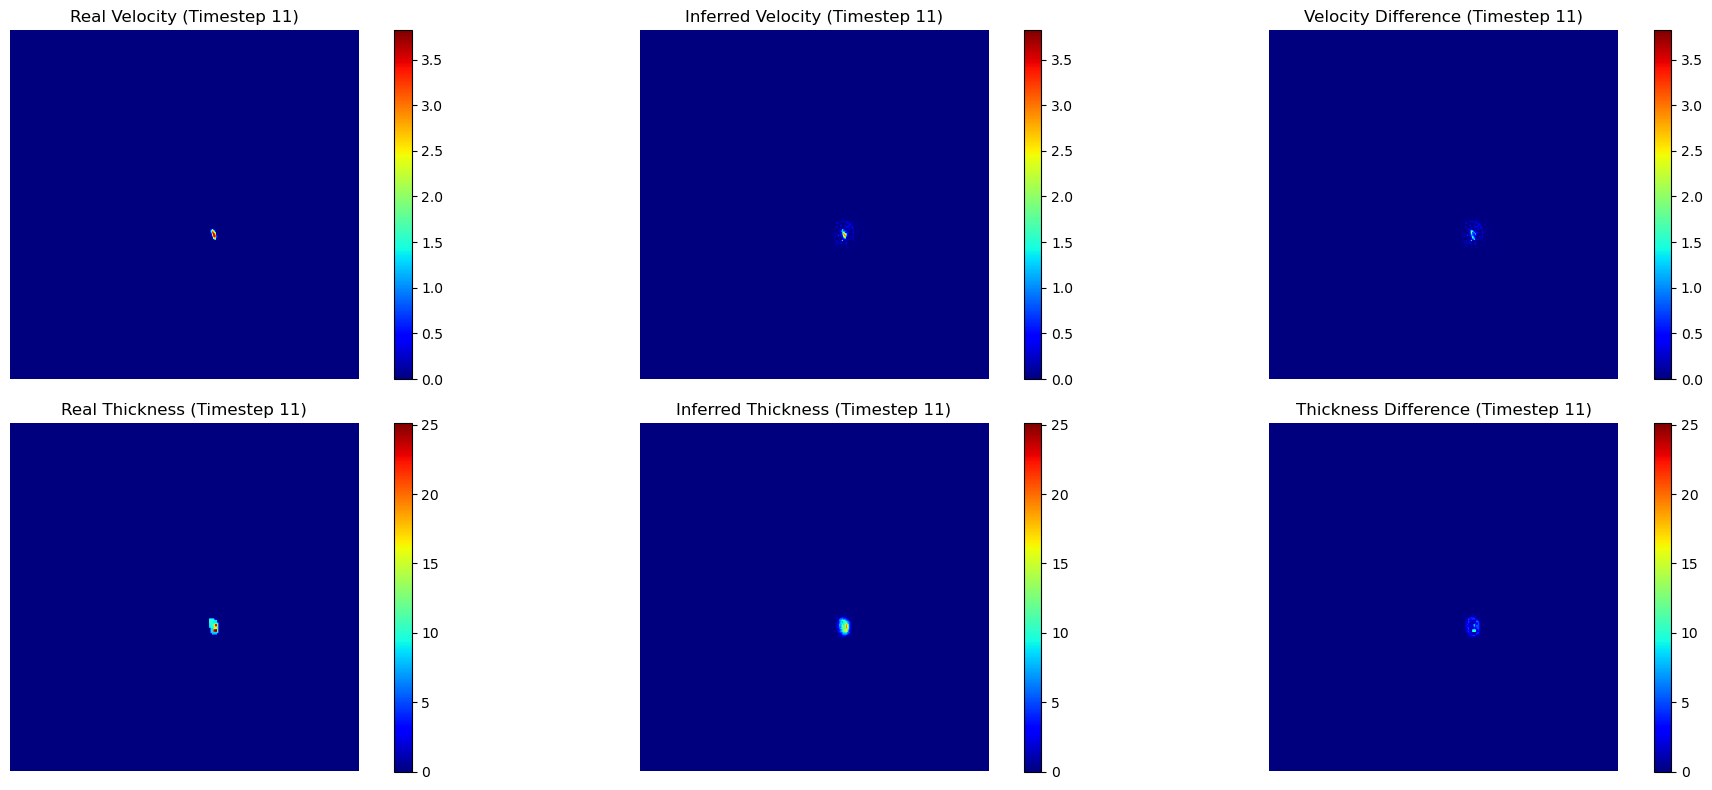

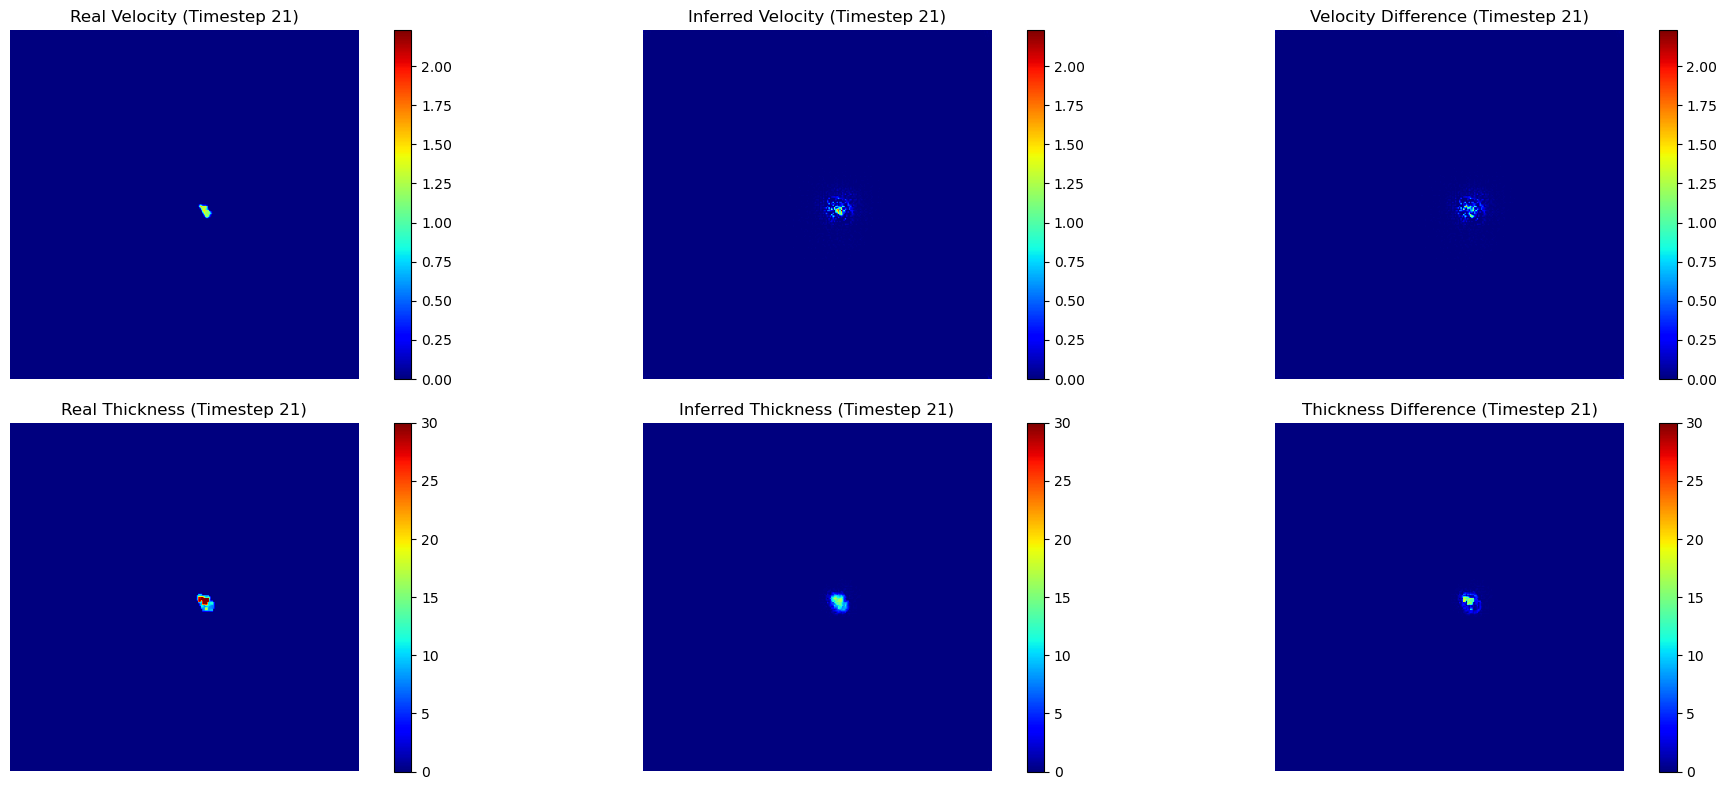

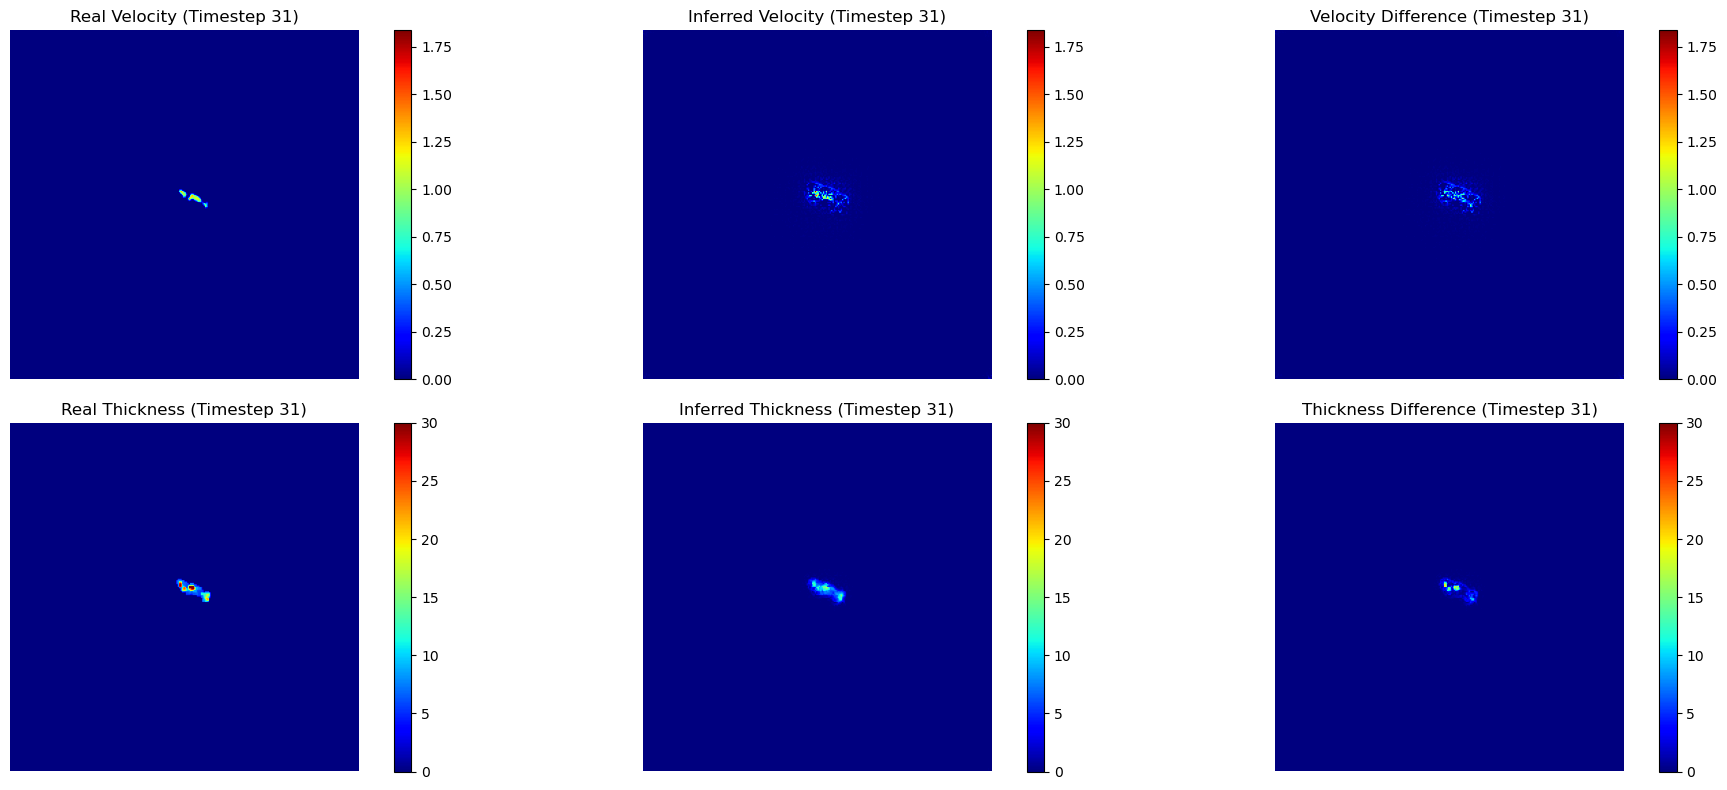

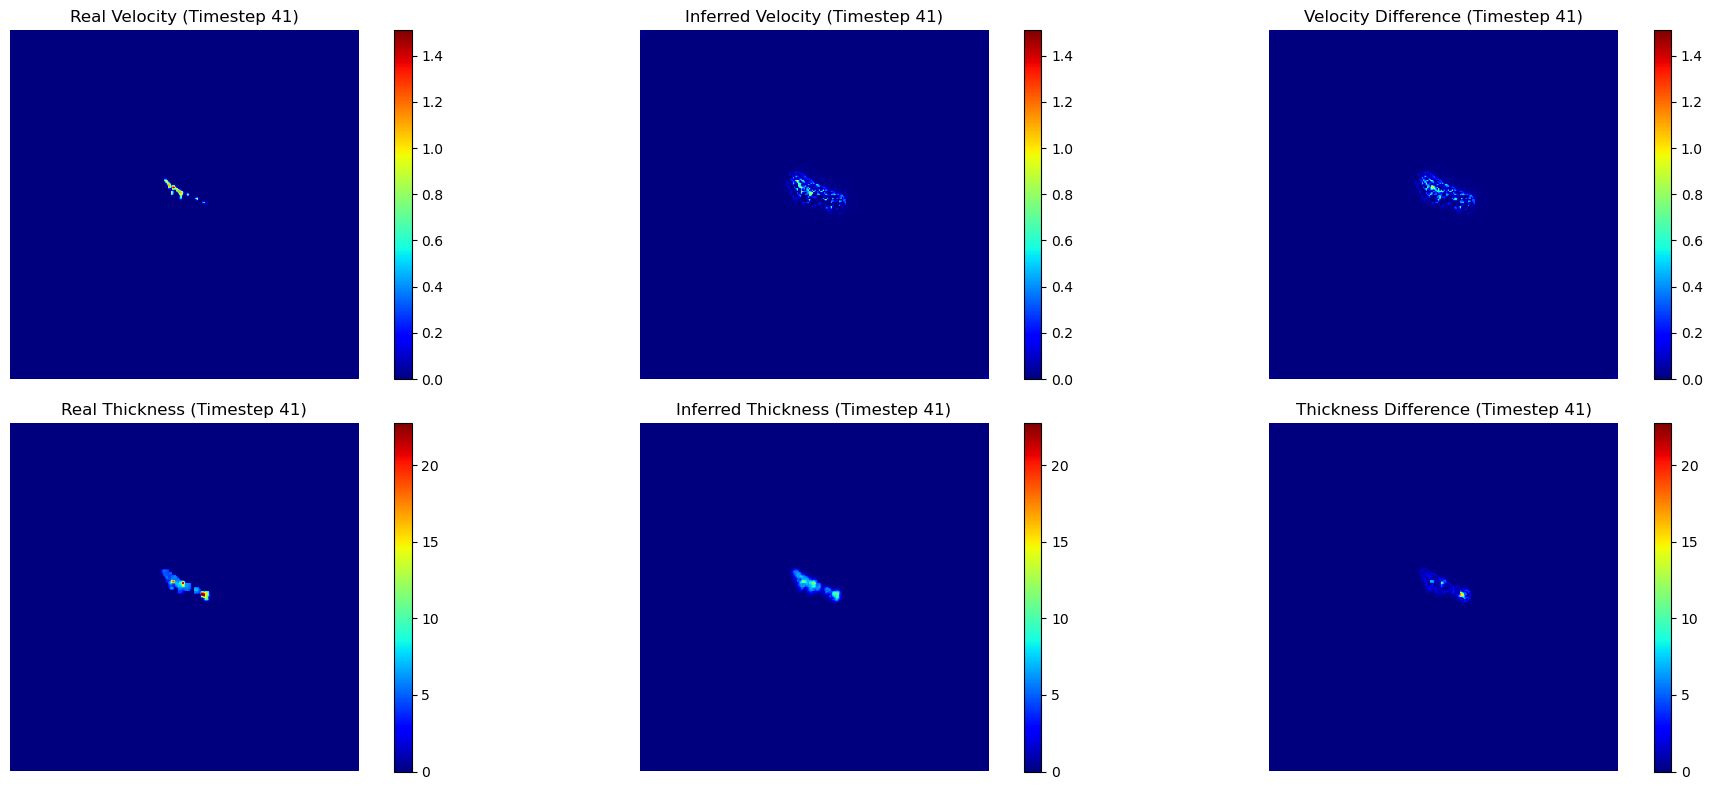

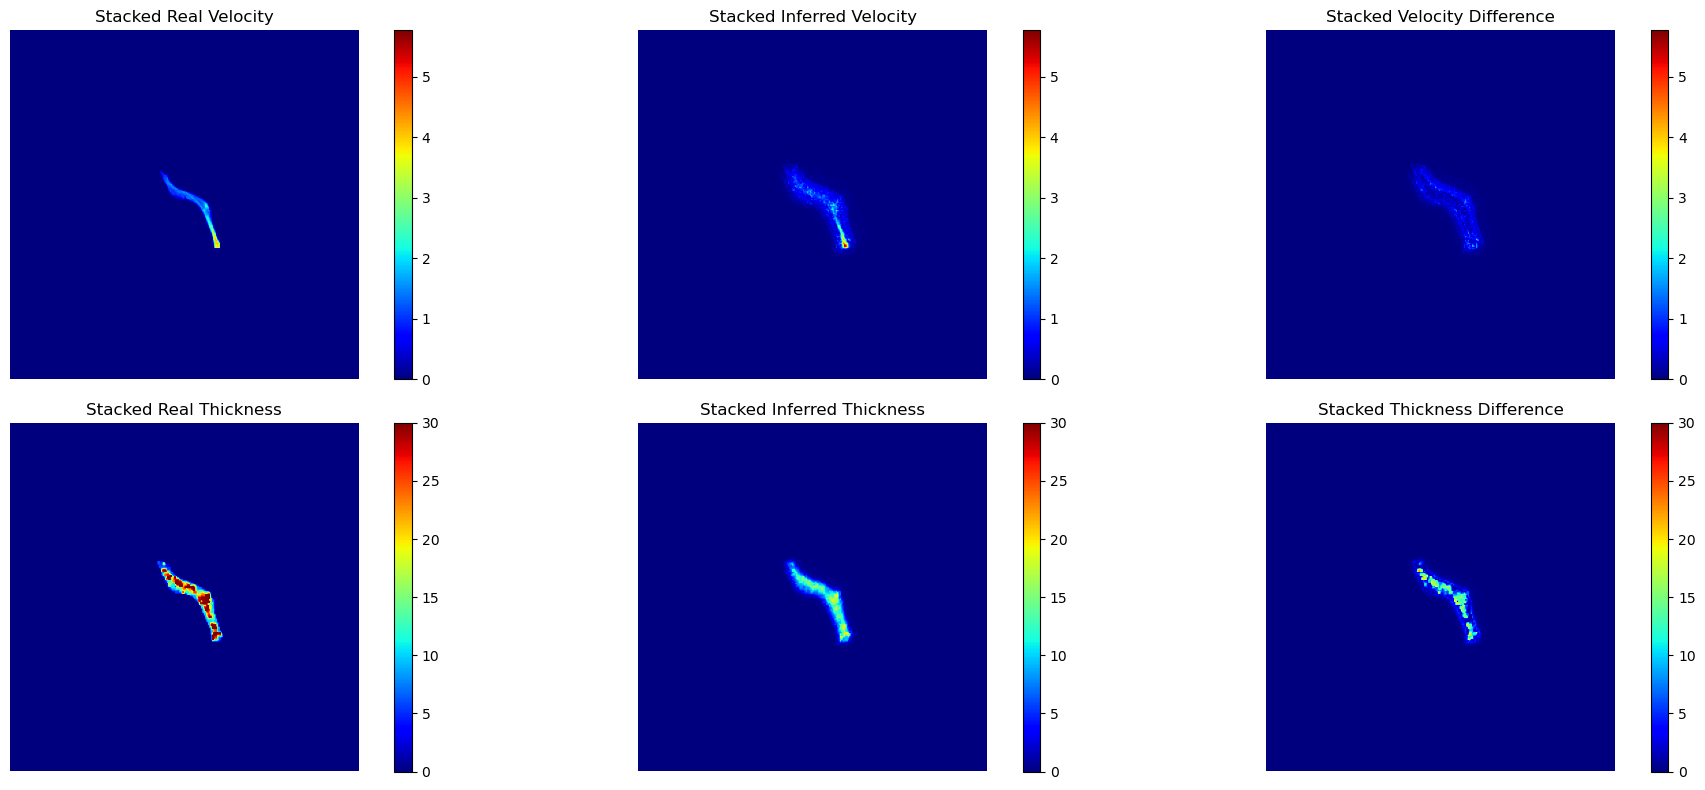

In [15]:
plot_real_vs_inferred(real_states, state_infer, n=n, model_id=model, base_folder=base_folder, suffix='pairs')